In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import hdbscan

In [18]:
df = pd.read_csv(r"C:\Users\MY PC\Desktop\influencers_log_and_minmax_scaled.csv")
features = df.columns.tolist()
raw_data = df[features].copy()

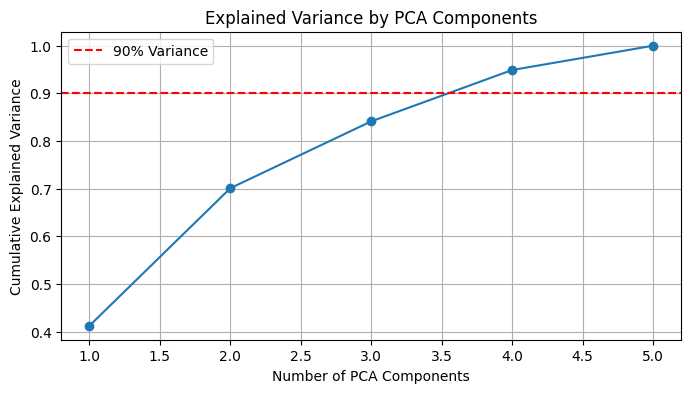

Number of components needed to retain 90% variance: 4


In [19]:
pca = PCA().fit(raw_data)
explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(explained_variance >= 0.90) + 1

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Variance')
plt.xlabel("Number of PCA Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.legend()
plt.show()

print(f"Number of components needed to retain 90% variance: {n_components}")


In [20]:
pca_vis = PCA(n_components=4)
X_vis = pca_vis.fit_transform(raw_data)

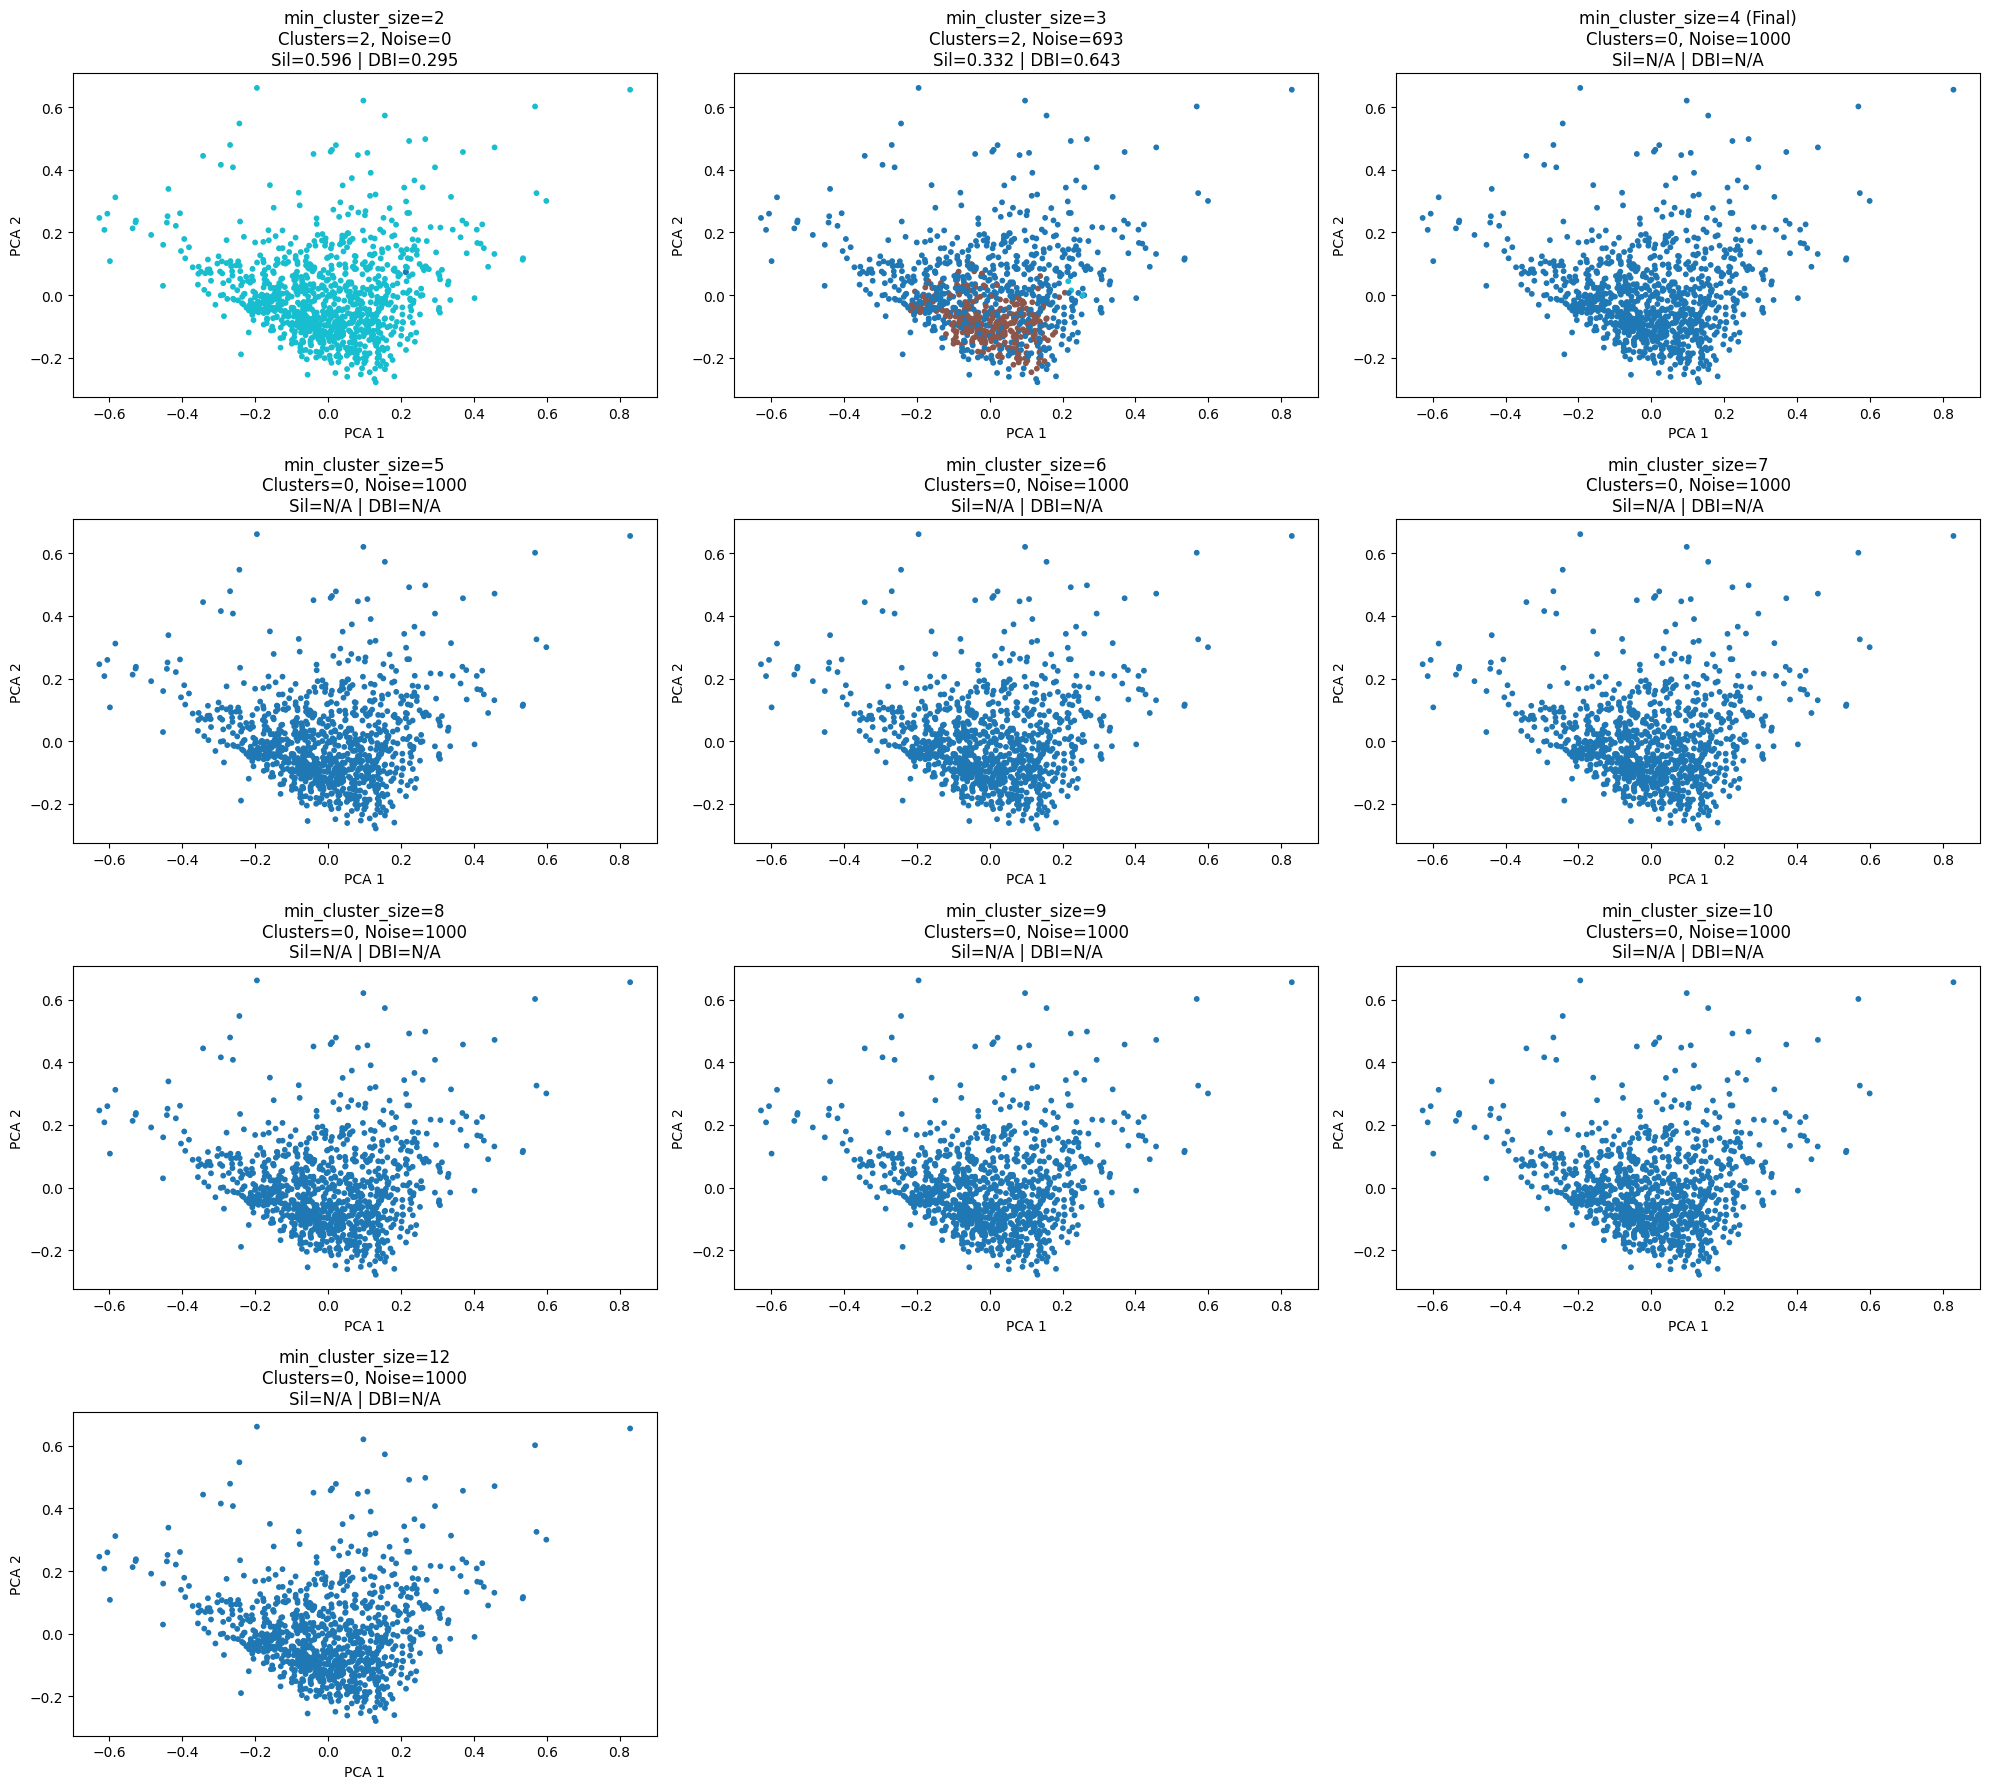

In [25]:
# Parameters
cluster_sizes = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12]
min_samples = 10
random_seed = 42

# Subplot Grid with Independent Runs (using fixed random seed)
plt.figure(figsize=(20, 18))
summary_list = []

for i, size in enumerate(cluster_sizes):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=size, min_samples=min_samples)
    clusterer.fit(raw_data)
    labels = clusterer.labels_

    # PCA (separate but deterministic)
    pca = PCA(n_components=2, random_state=random_seed)
    X_vis = pca.fit_transform(raw_data)

    # Cluster stats
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = np.sum(labels == -1)

    valid_mask = labels != -1
    if np.sum(valid_mask) > 1 and n_clusters > 1:
        sil = silhouette_score(raw_data[valid_mask], labels[valid_mask])
        dbi = davies_bouldin_score(raw_data[valid_mask], labels[valid_mask])
    else:
        sil = None
        dbi = None

    summary_list.append({
        "min_cluster_size": size,
        "clusters": n_clusters,
        "noise_points": n_noise,
        "silhouette": round(sil, 3) if sil is not None else "N/A",
        "dbi": round(dbi, 3) if dbi is not None else "N/A"
    })

    # Plot
    ax = plt.subplot(4, 3, i + 1)
    ax.scatter(X_vis[:, 0], X_vis[:, 1], c=labels, cmap='tab10', s=10)
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')
    highlight = " (Final)" if size == final_mcs else ""
    ax.set_title(
        f"min_cluster_size={size}{highlight}\nClusters={n_clusters}, Noise={n_noise}\n"
        f"Sil={round(sil, 3) if sil is not None else 'N/A'} | "
        f"DBI={round(dbi, 3) if dbi is not None else 'N/A'}"
    )

plt.tight_layout()
plt.show()

In [26]:
summary_df = pd.DataFrame(summary_list)
from IPython.display import display
display(summary_df)


,min_cluster_size,clusters,noise_points,silhouette,dbi
0,2,2,0,0.596,0.295
1,3,2,693,0.332,0.643
2,4,0,1000,N/A,N/A
3,5,0,1000,N/A,N/A
4,6,0,1000,N/A,N/A
5,7,0,1000,N/A,N/A
6,8,0,1000,N/A,N/A
7,9,0,1000,N/A,N/A
8,10,0,1000,N/A,N/A
9,12,0,1000,N/A,N/A


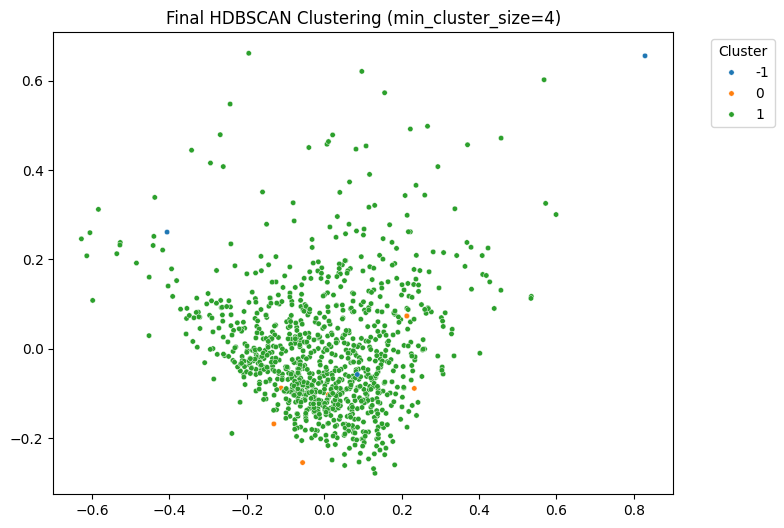

Cluster counts:
 -1      3
 0      7
 1    990
Name: count, dtype: int64


In [23]:
final_mcs = 4
clusterer = hdbscan.HDBSCAN(min_cluster_size=final_mcs)
labels_raw = clusterer.fit_predict(raw_data)

pca_final = PCA(n_components=n_components)
X_final = pca_final.fit_transform(raw_data)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_final[:, 0], y=X_final[:, 1], hue=labels_raw, palette='tab10', s=15)
plt.title(f"Final HDBSCAN Clustering (min_cluster_size={final_mcs})")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

print("Cluster counts:\n", pd.Series(labels_raw).value_counts().sort_index())